In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [16]:
IMAGE_SIZE = 256
CHANNEL = 3
EPOCHS = 15
BATCH_SIZE = 32

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "WHOLE_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names

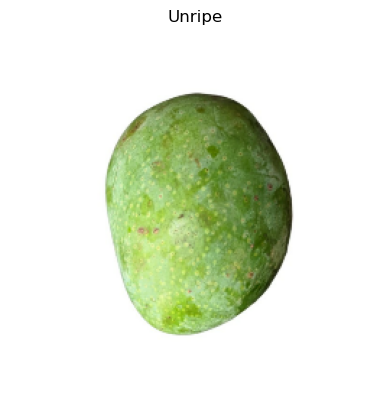

In [18]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [19]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

In [24]:
resnet_model = models.Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL),
    pooling='avg',
    classes=3,  # Change to 3 for three classes
    weights='imagenet'
)

In [25]:
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(resize)
resnet_model.add(augmentation)
resnet_model.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input))
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(3, activation='softmax'))

resnet_model.build((None, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))

In [26]:
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                

In [28]:
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
24/24 [==============================] - 156s 6s/step - loss: 0.3147 - accuracy: 0.9414 - val_loss: 0.1671 - val_accuracy: 0.9688
Epoch 2/15
24/24 [==============================] - 175s 7s/step - loss: 0.2551 - accuracy: 0.9401 - val_loss: 0.1442 - val_accuracy: 0.9583
Epoch 3/15
24/24 [==============================] - 174s 7s/step - loss: 0.2514 - accuracy: 0.9427 - val_loss: 0.1862 - val_accuracy: 0.9375
Epoch 4/15
24/24 [==============================] - 104s 4s/step - loss: 0.2292 - accuracy: 0.9414 - val_loss: 0.1662 - val_accuracy: 0.9479
Epoch 5/15
24/24 [==============================] - 128s 5s/step - loss: 0.2337 - accuracy: 0.9401 - val_loss: 0.1384 - val_accuracy: 0.9583
Epoch 6/15
24/24 [==============================] - 117s 5s/step - loss: 0.2456 - accuracy: 0.9427 - val_loss: 0.1507 - val_accuracy: 0.9479
Epoch 7/15
24/24 [==============================] - 157s 7s/step - loss: 0.2342 - accuracy: 0.9401 - val_loss: 0.2689 - val_accuracy: 0.9583
Epoch 8/15
24

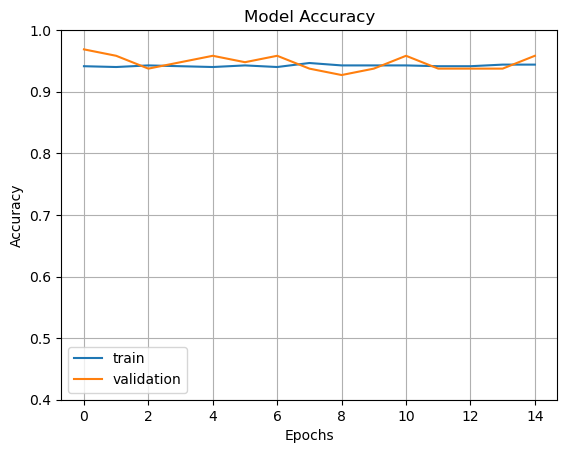

In [29]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

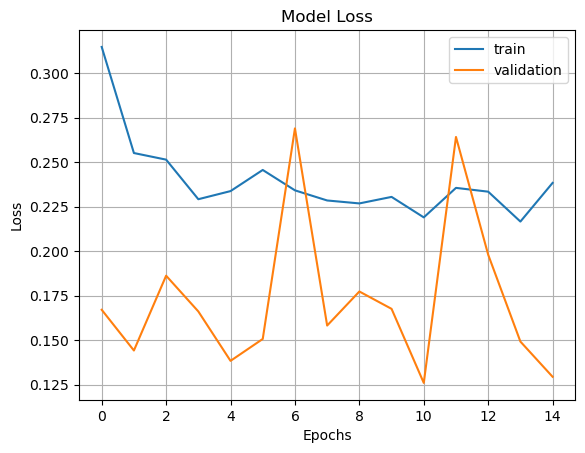

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [31]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class= class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 333ms/step


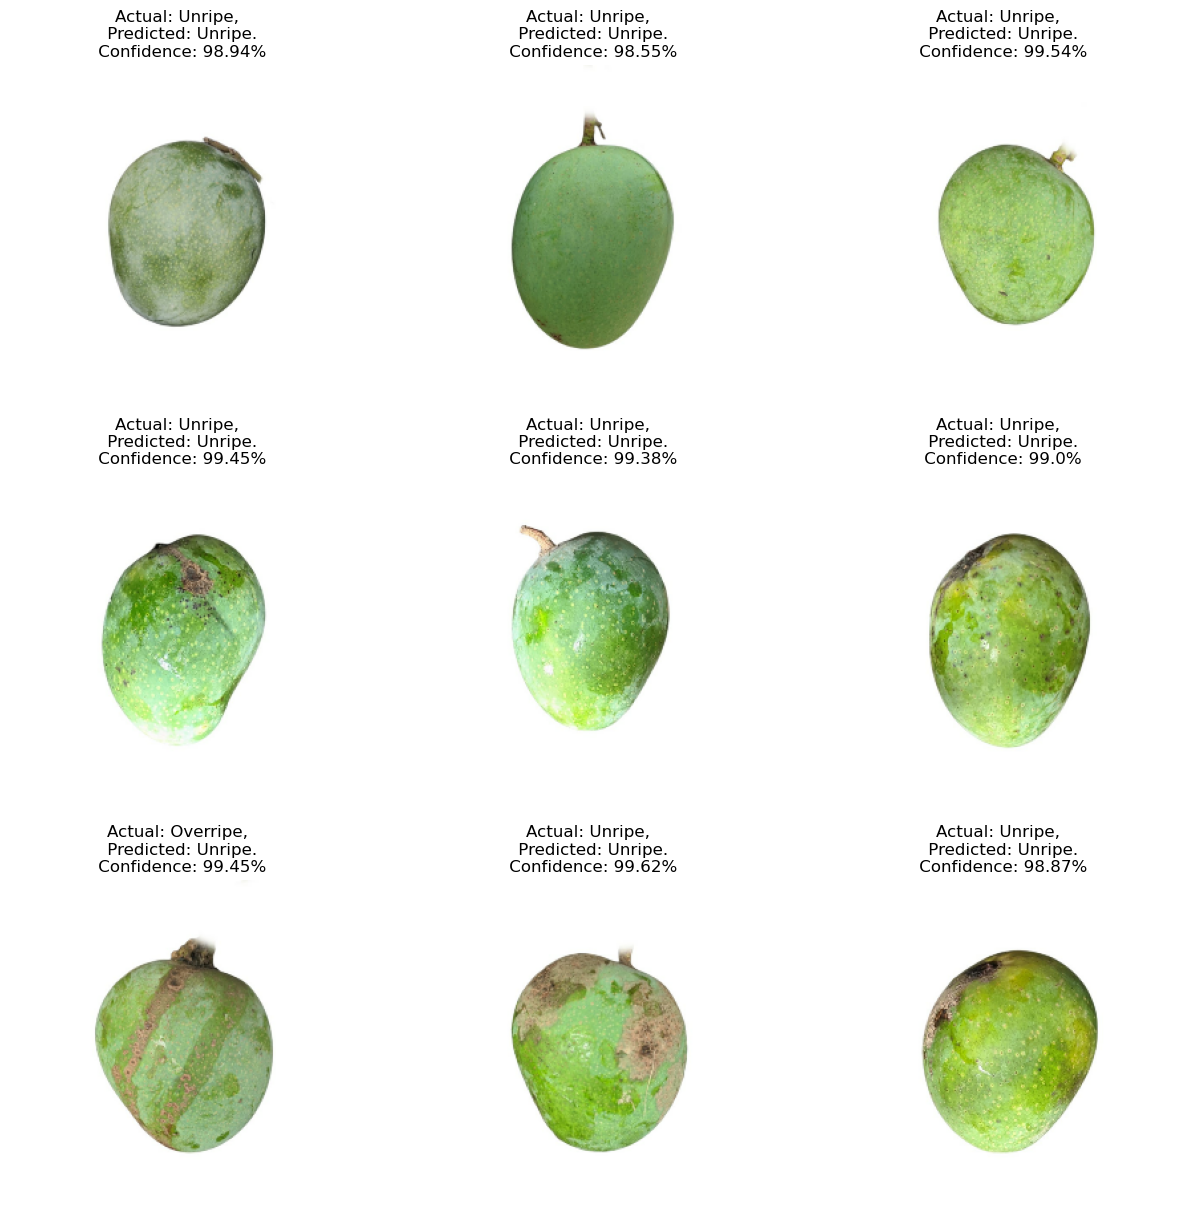

In [32]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence= predict(resnet_model, images[i].numpy())
        actual_class= class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

In [34]:
scores=resnet_model.evaluate(test_ds)

4/4 [==============================] - 29s 7s/step - loss: 0.2018 - accuracy: 0.9453
